<a href="https://colab.research.google.com/github/shahariaekran/test_demo/blob/master/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

plt.style.use('seaborn')

In [ ]:
# getting the data
url = "https://raw.githubusercontent.com/asifabdullah-git/Named-Entity-Recognition/main/Data/ner_dataset.csv"
data = pd.read_csv(url, encoding = "latin1")

In [ ]:
# drop the POS column because we dont need it
data = data.drop('POS', 1)

In [ ]:
print(data.head())
print("shape of dataset: " , data.shape)

    Sentence #           Word Tag
0  Sentence: 1      Thousands   O
1          NaN             of   O
2          NaN  demonstrators   O
3          NaN           have   O
4          NaN        marched   O
shape of dataset:  (1048575, 3)


In [ ]:
# Fill na
data = data.fillna(method = 'ffill')
print(data.head())

    Sentence #           Word Tag
0  Sentence: 1      Thousands   O
1  Sentence: 1             of   O
2  Sentence: 1  demonstrators   O
3  Sentence: 1           have   O
4  Sentence: 1        marched   O


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

print(words)
print(f"Total number of unique words in dataset: {num_words}")

['pile-up', 'Joyful', 'mature', 'acclaimed', 'Bhagwagar', 'sterilization', 'Nawab', 'audiotapes', 'Burma-Thailand', 'Mayor', 'audience', 'warfare', 'tying', 'generates', 'Yvon', 'Santo', 'PresseWednesday', 'Gazans', 'Achouri', 'betrayal', 'quo', '2.07.51', 'life-bearing', '617', 'spike', 'Kroes', 'Memin', 'earnest', 'busied', 'rabbi', '442', 'Velvet', 'Carlsen', 'chemistry', 'onboard', 'Yale', 'threat', 'tall', 'Award', 'clemency', 'safe', 'brigade', 'Fathi', 'EDC', 'doomed', 'Ullman', 'flood-damaged', 'paratroopers', 'Casey', 'bail', 'Soyuzcapsule', 'Corpus', 'Peyton', 'Trace', 'pre-trial', 'paperwork', 'dovish', 'rocked', 'heat-trapping', 'Himat', 'Katarina', 'Notes', 'Prizren', 'mansions', 'Brooklyn', 'milk', 'New', 'scandalized', 'manipulation', '8.9', 'USPI', '828-kilometer', 'rejoining', '26-year', 'writings', 'backyard', 'al-Mahdi', 'Catarrh', 'occurrence', 'integral', 'scuttle', 'al-Qaida', 'ca.', 'mirrored', 'Makepeace', '7.75', 'Shegag', 'integrate', 'recruits', 'Anti-Chinese

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: B-org, B-geo, I-art, B-eve, B-tim, I-geo, I-nat, I-per, B-nat, I-org, I-eve, B-art, O, B-per, I-gpe, B-gpe, I-tim
Total Number of tags 17


In [ ]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = Get_sentence(data)
sentence = getter.sentences

In [ ]:
sentence[100]

[('She', 'O'),
 ('was', 'O'),
 ('a', 'O'),
 ('longtime', 'O'),
 ('member', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('Zapatista', 'B-geo'),
 ('movement', 'O'),
 ('and', 'O'),
 ('appeared', 'O'),
 ('in', 'O'),
 ('public', 'O'),
 ('wearing', 'O'),
 ('a', 'O'),
 ('black', 'O'),
 ('ski', 'O'),
 ('mask', 'O'),
 ('.', 'O')]

Number of Sentences: 47959
Maximum sequence length: 104
Number of unique words: 35179


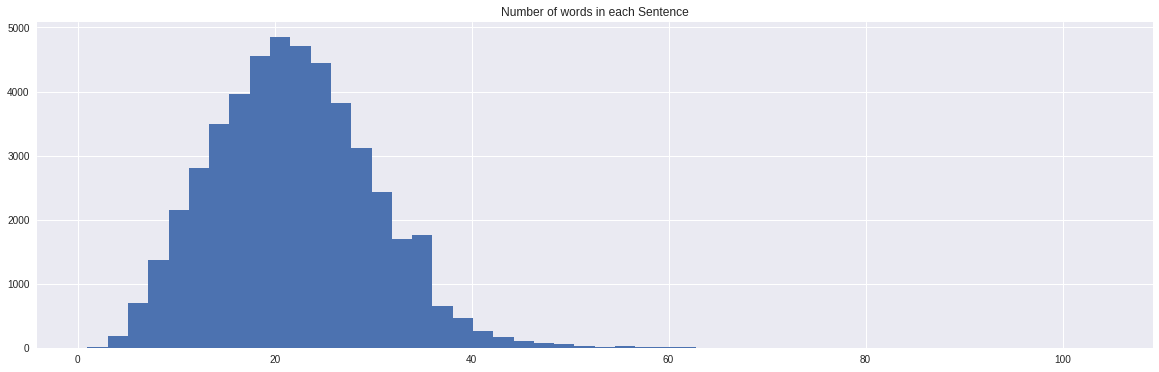

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentence], bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = max([len(s) for s in sentence])
print('Number of Sentences:', len(sentence))
print ('Maximum sequence length:', maxlen)

words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words)
print('Number of unique words:', n_words)

Number of unique Tags: 17


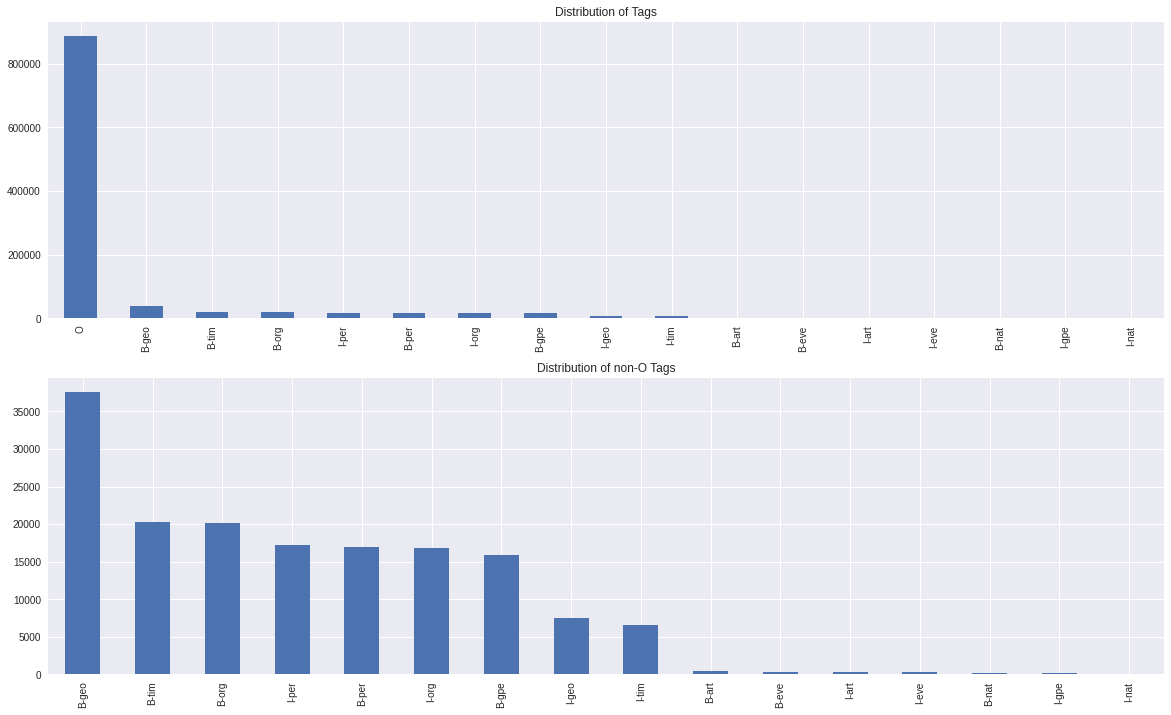

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.Tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.Tag != 'O'].Tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["Tag"].values))
n_tags = len(tags)
print('Number of unique Tags:', n_tags)

In [ ]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [ ]:
print(word_idx)
print(tag_idx)

{'for': 1, 'Airline': 2, 'stroke': 3, 'complaining': 4, 'opens': 5, '117-ball': 6, 'builders': 7, 'dousing': 8, 'Gemelli': 9, 'Naval': 10, 'testimony': 11, 'fours': 12, 'camp': 13, 'crisp': 14, 'wider': 15, 'yesterday': 16, 'Caraballo': 17, 'Russian': 18, 'Epiphany': 19, 'outraged': 20, 'demostrators': 21, 'suitor': 22, 'desecration': 23, 'joint': 24, 'distorts': 25, 'Tuomioja': 26, 'parishes': 27, 'superjumbo': 28, '472': 29, 'Tayyip': 30, 'smog': 31, 'Amritsar': 32, 'acquitted': 33, 'bbl/day': 34, 'Pu': 35, 'Mountains': 36, 'Alimport': 37, 'unknown': 38, 'surprises': 39, 'shortage': 40, 'Symptoms': 41, 'Slim': 42, 'Vicente': 43, 'banks': 44, 'female': 45, 'infiltration': 46, 'Intoning': 47, '1806': 48, 'Such': 49, 'XDR': 50, 'pouch': 51, 'scaled': 52, '70s': 53, 'lingered': 54, 'Musab': 55, 'Rehman': 56, 'run-up': 57, 'gunfire': 58, 'bargains': 59, 'Haswa': 60, 'funneled': 61, 'Sino-Japanese': 62, 'demerits': 63, 'Trafficking': 64, 'guesthouse': 65, 'Chodo': 66, 'Khalifa': 67, 'healt

# Model

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Embedding,TimeDistributed, LSTM, Dropout, Bidirectional, Dense 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical

In [ ]:
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag_idx[w[1]] for w in s] for s in sentence]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag_idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape)

X shape (47959, 104) y shape (47959, 104, 17)


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size = 0.20, random_state = 1)

In [ ]:
class config():
    VOCAB = n_words   #unique words
    MAX_LEN = maxlen  
    N_OUPUT = n_tags  
    
    
    EMBEDDING_VECTOR_LENGTH = 64
    N_LSTM_CELLS = 128
    RECURRENT_DROPOUT = 0.2
    
    OUTPUT_ACTIVATION = 'softmax'
    
    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    METRICS = ['accuracy']
    
    MAX_EPOCHS = 5

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 256)          197632    
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           4369      
Total params: 2,453,457
Trainable params: 2,453,457
Non-trainable params: 0
_________________________________________________________________


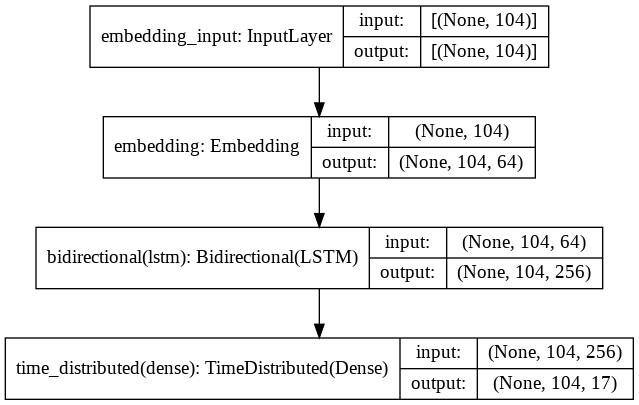

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
#filepath = "model.h5"
#ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

model = Sequential()
model.add(
    Embedding(
        input_dim=config.VOCAB, output_dim=config.EMBEDDING_VECTOR_LENGTH, input_length=config.MAX_LEN
    )
)
model.add(
    Bidirectional(
        LSTM(config.N_LSTM_CELLS, return_sequences=True, recurrent_dropout=config.RECURRENT_DROPOUT)
    )
)
model.add(
    TimeDistributed(
        Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION)
    )
)
model.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

model.summary()
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(x=X, y=y, batch_size = 64, validation_split=0.25,
    #callbacks=[es, ckpt, rlp], epochs=config.MAX_EPOCHS
    callbacks=es, epochs=config.MAX_EPOCHS
)

Epoch 1/5
 25/563 [>.............................] - ETA: 5:44 - loss: 0.0120 - accuracy: 0.9959

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(x_test,y_test)

375/375 [==============================] - 24s 63ms/step - loss: 0.0141 - accuracy: 0.9957


[0.014057022519409657, 0.9957448244094849]

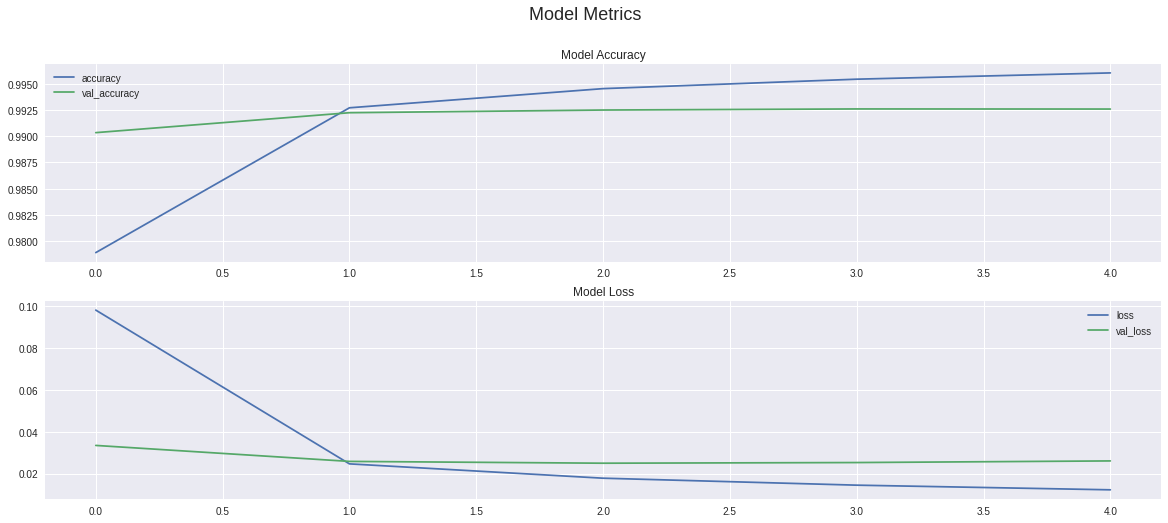

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);


In [ ]:
i = np.random.randint(0, X.shape[0])
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]

print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD': 
        break

Word           True 	Pred
------------------------------
operatives     B-geo	B-geo
DN             O	O
oil-for-food   O	O
vied           O	O
Capt.          O	O
bordering      O	O
enthusiastic   B-geo	B-geo
candidacy      I-geo	I-geo
Aweys          O	O
Pleshkov       B-tim	B-tim
Ski            O	O
Javad          O	O
vied           O	O
passport-forgingB-org	B-org
Pristina       I-org	I-org
Mai            I-org	I-org
11-style       O	O
Dengfeng       O	O
immunizing     B-gpe	B-gpe
lighthouses    O	O
Participation  O	O
fearing        O	O
Ballack        O	O
Funeral        O	O
bordering      O	O
vied           O	O
Ranbir         B-geo	B-geo
VWR            O	O
ENDPAD         O	O
